In [220]:
import os
import pickle
import warnings
import datetime
import sys

import boto3
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.sklearn.model import SKLearnModel


import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay, calibration_curve

sys.path.append('/home/ec2-user/SageMaker/customer-churn/')
from src.custom_utils import load_data

import matplotlib.pyplot as plt
fig_size = (12, 10)

## S3 & SageMaker

In [144]:
s3 = boto3.client('s3')

s3_bucket = 'yang-ml-sagemaker'
s3_key = 'customer_churn'
train_test_key = os.path.join(s3_key, 'train_test')

data_path = {'train': f's3://{s3_bucket}/{train_test_key}'}
data_path

{'train': 's3://yang-ml-sagemaker/customer_churn/train_test'}

In [145]:
sagemaker_session = sagemaker.Session(default_bucket=s3_bucket)
sagemaker_session
sm_boto3 = boto3.client('sagemaker')
role = sagemaker.get_execution_role()


src_dir_path = '/home/ec2-user/SageMaker/customer-churn/src'
# This should be a child directory inside src
training_script_path = 'training_inference_entry.py'
FRAMEWORK_VERSION = '1.2-1'


# Get today's date in YYYYMMDD format
today = datetime.datetime.today().strftime('%Y-%m-%d')

# Define endpoint name with version and date
endpoint_name = f'customer-churn-prediction-{today}'

## SageMaker Estimator

In [182]:
sklearn_estimator = SKLearn(
    entry_point=training_script_path,
    role=role,
    instance_type='ml.c5.2xlarge', # 8 vCPU, 16 GiB memory, $0.408 per hour
    instance_count=1,
    framework_version=FRAMEWORK_VERSION,
    py_version='py3',
    source_dir=src_dir_path,
    output_path=f's3://{s3_bucket}/{s3_key}/model'
)

In [183]:
# Training job
sklearn_estimator.fit(data_path) 

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2023-04-17-06-18-03-757


2023-04-17 06:18:04 Starting - Starting the training job...
2023-04-17 06:18:19 Starting - Preparing the instances for training...
2023-04-17 06:19:04 Downloading - Downloading input data.....2023-04-17 06:19:55,688 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-04-17 06:19:55,690 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-17 06:19:55,697 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-04-17 06:19:55,880 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 104.0 MB/s eta 0:00:00
  

In [184]:
# Documentation at https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/describe_training_job.html
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)

Model artifact persisted at s3://yang-ml-sagemaker/customer_churn/model/sagemaker-scikit-learn-2023-04-17-06-18-03-757/output/model.tar.gz


## Deploy Model to An Endpoint

Deploy directly from estimator:

In [185]:
predictor_direct = sklearn_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.2xlarge',
    endpoint_name=endpoint_name + '-v1'
)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2023-04-17-06-21-00-025
INFO:sagemaker:Creating endpoint-config with name customer-churn-prediction-2023-04-17-v1
INFO:sagemaker:Creating endpoint with name customer-churn-prediction-2023-04-17-v1


----!

Invoke using Python SKD:

In [186]:
# Read in test data
X_test, y_test = load_data(data_s3_url=os.path.join(data_path['train'], 'test.csv'))
X_test.shape, y_test.shape

((1409, 34), (1409,))

In [187]:
# The default SKLearnPredictor has 'application/x-npy' serializer
y_pred = predictor_direct.predict(
    data=X_test,
    initial_args={
        'ContentType': 'application/x-npy'
    }
)

## Evaluation on Test Set

In [196]:
print(classification_report(
    y_test,
    y_pred.argmax(axis=1)
))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      1035
           1       0.83      0.96      0.89       374

    accuracy                           0.94      1409
   macro avg       0.91      0.95      0.93      1409
weighted avg       0.94      0.94      0.94      1409



### PR Curve

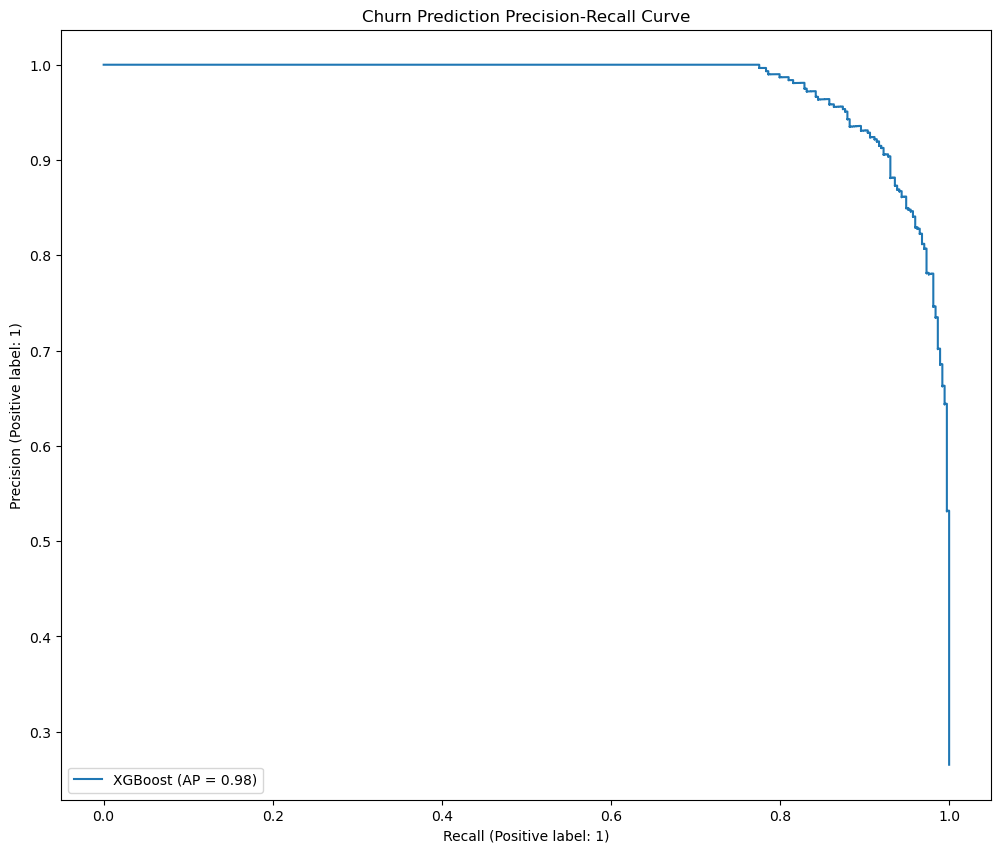

In [221]:
fig, ax = plt.subplots(figsize=fig_size)
PrecisionRecallDisplay.from_predictions(y_test, y_pred[:, 1], name='XGBoost', ax=ax)
plt.title('Churn Prediction Precision-Recall Curve')
plt.show();

### Calibration Curve

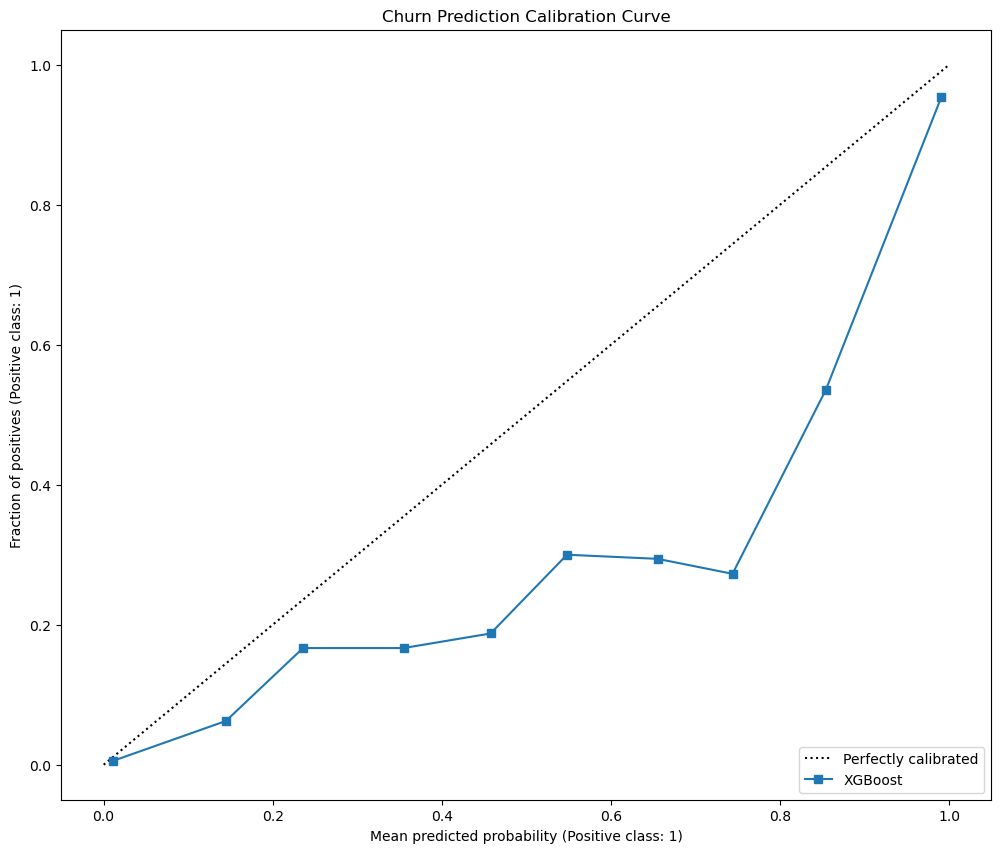

In [222]:
fig, ax = plt.subplots(figsize=fig_size)
CalibrationDisplay.from_predictions(y_test, y_pred[:, 1], n_bins=10, name='XGBoost', ax=ax)
plt.title('Churn Prediction Calibration Curve')
plt.show();

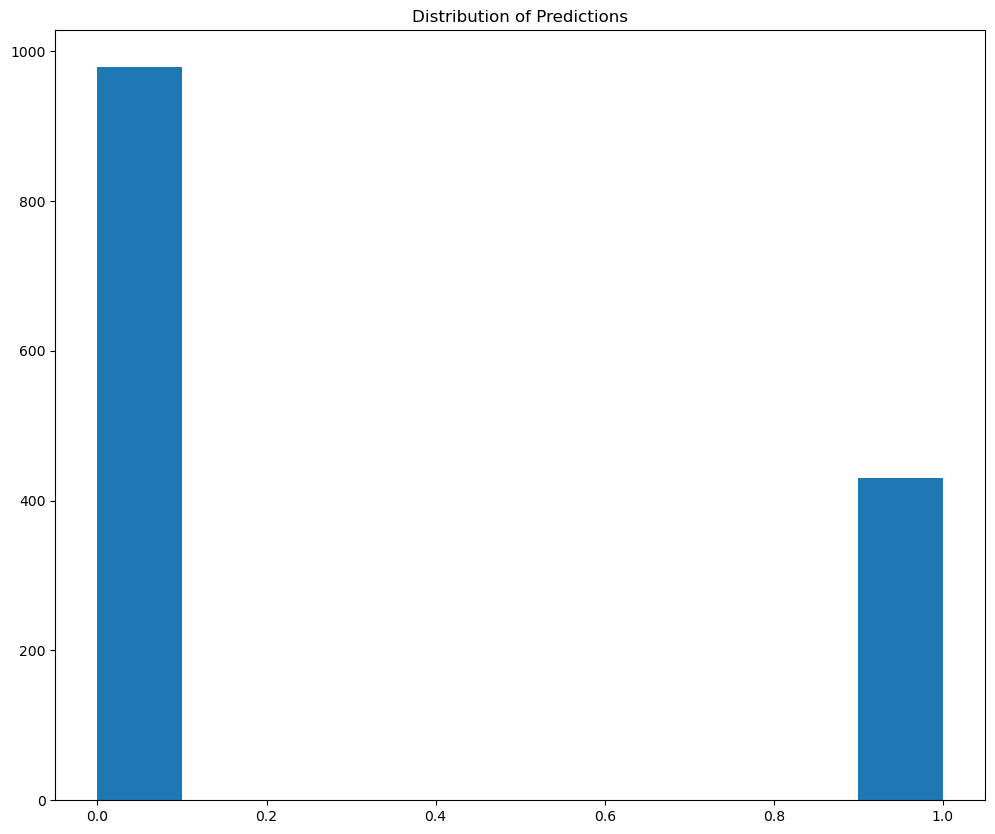

In [223]:
fig, ax = plt.subplots(figsize=fig_size)
ax.hist(y_pred.argmax(axis=1))
plt.title('Distribution of Predictions')
plt.show();

## Clean-up

In [224]:
sm_boto3.delete_endpoint(EndpointName=predictor_direct.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor_direct.endpoint_name)

{'ResponseMetadata': {'RequestId': 'f86eac33-2e49-4799-a321-7fbafef739b2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f86eac33-2e49-4799-a321-7fbafef739b2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 17 Apr 2023 06:57:29 GMT'},
  'RetryAttempts': 0}}